# Models with inputs (features)
## TASK 10
### Importing data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from prophet import Prophet
except ImportError:
    from fbprophet import Prophet


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def nrmse(y_true, y_pred):
    # normalised by range of true values (per evaluation block)
    denom = (np.max(y_true) - np.min(y_true))
    return rmse(y_true, y_pred) / denom if denom != 0 else np.nan

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


## Load + hourly grid + interpolation

In [3]:
def preprocess_hourly(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("timestamp").set_index("timestamp")
    # tz -> naive
    try:
        df.index = df.index.tz_convert(None)
    except Exception:
        df.index = df.index.tz_localize(None)

    df = df.resample("h").asfreq()

    # interpolate numeric columns
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c] = df[c].interpolate(method="time").ffill().bfill()

    df.index.freq = "h"
    return df

train = preprocess_hourly(pd.read_csv("train_253253.csv", parse_dates=["timestamp"]))
fcst  = preprocess_hourly(pd.read_csv("forecast.csv",      parse_dates=["timestamp"]))

train.head()


,pv_mod1,pv_mod2,pv_mod3,Demand,pv,Price,Temperature,Pressure (hPa),Cloud_cover (%),Cloud_cover_low (%),Cloud_cover_mid (%),Cloud_cover_high (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),daymax
timestamp,,,,,,,,,,,,,,,,,,
2013-07-01 00:00:00,0.0,0.0,0.0,0.27,0.0,0.01605,13.5,1011.3,4.0,0.0,0.0,3.0,10.5,270.0,0.0,0.0,0.0,3.56
2013-07-01 01:00:00,0.0,0.0,0.0,0.23,0.0,0.00095,13.2,1010.8,27.0,1.0,2.0,23.0,11.9,270.0,0.0,0.0,0.0,3.56
2013-07-01 02:00:00,0.0,0.0,0.0,0.26,0.0,0.00060,13.1,1010.3,33.0,0.0,0.0,32.0,11.6,270.0,0.0,0.0,0.0,3.56
2013-07-01 03:00:00,0.0,0.0,0.0,0.28,0.0,0.00046,13.0,1010.3,28.0,0.0,0.0,27.0,11.2,270.0,2.0,7.0,30.1,3.56
2013-07-01 04:00:00,0.0,0.0,0.0,0.29,0.0,0.00046,13.8,1010.2,16.0,0.0,1.0,14.0,11.7,270.0,30.0,31.0,252.0,3.56


## Choose engineered features inputs 

In [6]:
# engineered features columns (must exist in BOTH train and forecast)
features_cols = ["Price", "Temperature"]

# quick sanity check
missing_train = [c for c in features_cols if c not in train.columns]
missing_fcst  = [c for c in features_cols if c not in fcst.columns]
print("Missing in train:", missing_train)
print("Missing in forecast:", missing_fcst)

Missing in train: []
Missing in forecast: []


## Rolling windows (7 days, 24h horizon, 0h lead time)

In [5]:
start_day = fcst.index.min().normalize()
day_starts = [start_day + pd.Timedelta(days=i) for i in range(7)]
print(day_starts)

windows = {}
for day_start in day_starts:
    day_end = day_start + pd.Timedelta(hours=24)

    # history available at 0h lead time
    hist = pd.concat([train, fcst.loc[:day_start - pd.Timedelta(hours=1)]], axis=0)

    # 24h block
    block = fcst.loc[day_start:day_end - pd.Timedelta(hours=1)].copy()

    windows[day_start] = {"hist": hist, "block": block}


[Timestamp('2014-07-01 00:00:00'), Timestamp('2014-07-02 00:00:00'), Timestamp('2014-07-03 00:00:00'), Timestamp('2014-07-04 00:00:00'), Timestamp('2014-07-05 00:00:00'), Timestamp('2014-07-06 00:00:00'), Timestamp('2014-07-07 00:00:00')]


## Statistical models with inputs
## Rolling evaluation: ARIMA baseline vs SARIMAX(+engineered features)

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

def _decomp_to_stat_series(y: pd.Series, period=24):
    """
    Classical decomposition -> returns
      y_stat: log1p(residual) (stationary target)
      trend_last: last trend value (scalar)
      seasonal_by_hour: mean seasonal profile by hour (Series indexed 0..23)
    """
    dec = seasonal_decompose(y, model="additive", period=period, extrapolate_trend="freq")
    trend = dec.trend
    seasonal = dec.seasonal
    resid = dec.resid

    y_stat = np.log1p(resid.dropna())
    trend_last = trend.dropna().iloc[-1]
    seasonal_by_hour = seasonal.groupby(seasonal.index.hour).mean()
    return y_stat, trend_last, seasonal_by_hour

def _restore_from_stat(yhat_stat, idx_future, trend_last, seasonal_by_hour):
    """Invert log1p and add back trend + seasonal to get Demand forecast."""
    resid_hat = np.expm1(np.asarray(yhat_stat))
    seasonal_future = np.array([seasonal_by_hour[h] for h in idx_future.hour])
    return resid_hat + trend_last + seasonal_future

def rolling_arima_vs_sarimax(windows, order=(4,0,1), features_cols=None, train_last_days=120, period=24):
    """
    Rolling day-by-day evaluation (24h horizon, 0h lead time):
      - Baseline: ARIMA on stationarised residuals (decomposition + log1p)
      - With inputs: SARIMAX on same residual target + engineered features as exog
    Metrics: MAE and NRMSE (Task 10 requirement).
    """
    rows = []
    preds = {"ARIMA": [], "SARIMAX_features": [], "Actual": []}

    for day_start, w in windows.items():
        hist = w["hist"].copy()
        block = w["block"].copy()

        # (for myself) speed-up: keep last N days of history
        hist = hist.loc[hist.index.max() - pd.Timedelta(days=train_last_days):]

        y_true  = block["Demand"].astype(float).values
        idx_fut = block.index

        # --- Build stationary target from decomposition residuals
        y_stat, trend_last, seasonal_by_hour = _decomp_to_stat_series(
            hist["Demand"].astype(float),
            period=period
        )

        # Align features with y_stat index (important!)
        X_train = hist.loc[y_stat.index, features_cols].astype(float)
        X_future = block[features_cols].astype(float)

        # Optional: standardize features to help convergence
        mu = X_train.mean()
        sd = X_train.std().replace(0, 1)
        X_train_s = (X_train - mu) / sd
        X_future_s = (X_future - mu) / sd

        # --- Baseline ARIMA (no features) on y_stat
        m_arima = ARIMA(y_stat, order=order).fit()
        yhat_arima_stat = m_arima.forecast(steps=24).values
        yhat_arima = _restore_from_stat(yhat_arima_stat, idx_fut, trend_last, seasonal_by_hour)

        # --- SARIMAX with engineered features (features) on same y_stat
        m_smx = SARIMAX(
            y_stat, exog=X_train_s,
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, maxiter=200)
        print(m_smx.mle_retvals)
        yhat_smx_stat = m_smx.forecast(steps=24, exog=X_future_s).values
        yhat_smx = _restore_from_stat(yhat_smx_stat, idx_fut, trend_last, seasonal_by_hour)

        # store for plots
        preds["Actual"].append(pd.Series(y_true, index=idx_fut))
        preds["ARIMA"].append(pd.Series(yhat_arima, index=idx_fut))
        preds["SARIMAX_features"].append(pd.Series(yhat_smx, index=idx_fut))

        # metrics per day
        rows.append({
            "day": day_start.date(),
            "ARIMA_MAE": mae(y_true, yhat_arima),
            "ARIMA_NRMSE": nrmse(y_true, yhat_arima),
            "SARIMAX_MAE": mae(y_true, yhat_smx),
            "SARIMAX_NRMSE": nrmse(y_true, yhat_smx),
        })

    return pd.DataFrame(rows), preds


# run
stat_results, stat_preds = rolling_arima_vs_sarimax(windows, order=(4,0,1), features_cols=features_cols, train_last_days=120, period=24)
stat_results


{'fopt': 0.0027027165517933055, 'gopt': array([-1.47905646e-06, -7.35801454e-06, -9.78305869e-06,  2.60432041e-06,
       -1.48924470e-05, -1.07955320e-05, -8.48310684e-06,  6.84025805e-06]), 'fcalls': 477, 'warnflag': 0, 'converged': True, 'iterations': 41}
{'fopt': 0.0037148186648484544, 'gopt': array([-6.49898343e-06, -3.26791415e-07,  2.16341103e-06,  2.29278554e-06,
        5.35823413e-06,  8.72788473e-06,  1.52410406e-06, -1.42998439e-05]), 'fcalls': 648, 'warnflag': 0, 'converged': True, 'iterations': 46}
{'fopt': 0.005803100520312856, 'gopt': array([ 5.13721806e-05,  4.65960953e-05, -2.70761321e-06, -6.47951935e-06,
        4.34196117e-06,  2.25742096e-05,  7.56846643e-06, -2.59671529e-06]), 'fcalls': 720, 'warnflag': 0, 'converged': True, 'iterations': 38}
{'fopt': -0.0020074994320900255, 'gopt': array([-3.82642885e-05, -2.31228551e-05,  4.69382805e-06,  9.63356868e-07,
       -8.63074781e-06, -8.73289726e-06,  5.67589725e-06, -8.53218533e-06]), 'fcalls': 468, 'warnflag': 0, '

C:\Raznoe\Code\envs\ITS8080\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'fopt': -0.015230417762323879, 'gopt': array([-2.54479580e-05, -2.95883934e-05,  8.69186494e-06,  1.86202841e-06,
       -8.79242981e-06, -1.54836845e-05, -3.11026517e-06,  1.64206185e-05]), 'fcalls': 432, 'warnflag': 0, 'converged': True, 'iterations': 33}


,day,ARIMA_MAE,ARIMA_NRMSE,SARIMAX_MAE,SARIMAX_NRMSE
0,2014-07-01,0.257603,0.208134,0.285811,0.213908
1,2014-07-02,0.240055,0.282452,0.240450,0.280556
2,2014-07-03,0.161290,1.429659,0.182727,1.656252
3,2014-07-04,0.165758,2.195767,0.131700,1.764912
4,2014-07-05,0.125954,1.693593,0.131454,1.622904
5,2014-07-06,0.125222,1.122834,0.121076,1.014121
6,2014-07-07,0.379437,0.300008,0.335523,0.282260


Occasional convergence warnings can occur for SARIMAX on short rolling windows; therefore, we validated the final fit status using mle_retvals. Forecast evaluation was reported only for the fitted models, using MAE and normalised RMSE.

## ML models with inputs
## Rolling evaluation: Prophet baseline vs Prophet(+regressors)

In [55]:
def fit_prophet(df_train, add_regs=None):
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
    m.add_country_holidays(country_name="EE")
    if add_regs:
        for r in add_regs:
            m.add_regressor(r)
    m.fit(df_train)
    return m

def rolling_prophet(windows, features_cols=None, train_last_days=60):
    rows = []
    preds = {"Prophet": [], "Prophet_features": [], "Actual": []}

    for day_start, w in windows.items():
        hist = w["hist"].copy()
        block = w["block"].copy()

        hist = hist.loc[hist.index.max() - pd.Timedelta(days=train_last_days):]

        # Prophet format
        df_train_base = hist[["Demand"]].reset_index()
        df_train_base.columns = ["ds", "y"]

        # baseline Prophet
        m0 = fit_prophet(df_train_base, add_regs=None)
        future0 = pd.DataFrame({"ds": block.index})
        yhat0 = m0.predict(future0)["yhat"].values

        # Prophet + features
        df_train_ex = hist[["Demand"] + features_cols].reset_index()
        df_train_ex.columns = ["ds", "y"] + features_cols
        m1 = fit_prophet(df_train_ex, add_regs=features_cols)

        future1 = pd.DataFrame({"ds": block.index})
        for c in features_cols:
            future1[c] = block[c].values
        yhat1 = m1.predict(future1)["yhat"].values

        y_true = block["Demand"].values

        preds["Actual"].append(pd.Series(y_true, index=block.index))
        preds["Prophet"].append(pd.Series(yhat0, index=block.index))
        preds["Prophet_features"].append(pd.Series(yhat1, index=block.index))

        rows.append({
            "day": day_start.date(),
            "Prophet_MAE": mae(y_true, yhat0),
            "Prophet_NRMSE": nrmse(y_true, yhat0),
            "ProphetEx_MAE": mae(y_true, yhat1),
            "ProphetEx_NRMSE": nrmse(y_true, yhat1),
        })

    return pd.DataFrame(rows), preds


ml_results, ml_preds = rolling_prophet(windows, features_cols=features_cols, train_last_days=60)
ml_results

21:15:39 - cmdstanpy - INFO - Chain [1] start processing
21:15:39 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:41 - cmdstanpy - INFO - Chain [1] done processing
21:15:41 - cmdstanpy - INFO - Chain [1] start processing
21:15:41 - cmdstanpy - INFO - Chain [1] done processing
21:15:41 - cmdstanpy - INFO - Chain [1] start processing
21:15:41 - cmdstanpy - INFO - Chain [1] done processing
21:15:41 - cmdstanpy - INFO - Chain [1] start processing
21:15:41 - cmdstanpy - INFO - Chain [1] done processing
21:15:42 - cmdstanpy - INFO - Chain [1] start processing
21:15:42 - cmdstanpy - INFO - Chain [1]

,day,Prophet_MAE,Prophet_NRMSE,ProphetEx_MAE,ProphetEx_NRMSE
0,2014-07-01,0.214311,0.195643,0.222016,0.194306
1,2014-07-02,0.213916,0.268170,0.224183,0.270774
2,2014-07-03,0.196356,1.715017,0.210280,1.843109
3,2014-07-04,0.236290,2.698092,0.252549,2.849421
4,2014-07-05,0.148123,2.000197,0.152387,2.040892
5,2014-07-06,0.153298,1.210460,0.163684,1.287766
6,2014-07-07,0.271838,0.243555,0.258767,0.235526


## Quantify improvements (Task 10.1)
## Summary tables + improvement vs autoregressive baselines

In [56]:
# mean over 7 days
stat_mean = pd.Series({
    "ARIMA_MAE": stat_results["ARIMA_MAE"].mean(),
    "ARIMA_NRMSE": stat_results["ARIMA_NRMSE"].mean(),
    "SARIMAX_MAE": stat_results["SARIMAX_MAE"].mean(),
    "SARIMAX_NRMSE": stat_results["SARIMAX_NRMSE"].mean(),
})

ml_mean = pd.Series({
    "Prophet_MAE": ml_results["Prophet_MAE"].mean(),
    "Prophet_NRMSE": ml_results["Prophet_NRMSE"].mean(),
    "ProphetEx_MAE": ml_results["ProphetEx_MAE"].mean(),
    "ProphetEx_NRMSE": ml_results["ProphetEx_NRMSE"].mean(),
})

print(stat_mean, ml_mean)

# Improvement tables (absolute and percent)
improvement = pd.DataFrame([
    {
        "Comparison": "SARIMAX(features) vs ARIMA",
        "ΔMAE": stat_mean["ARIMA_MAE"] - stat_mean["SARIMAX_MAE"],
        "ΔNRMSE": stat_mean["ARIMA_NRMSE"] - stat_mean["SARIMAX_NRMSE"],
        "%MAE_impr": 100 * (stat_mean["ARIMA_MAE"] - stat_mean["SARIMAX_MAE"]) / stat_mean["ARIMA_MAE"],
        "%NRMSE_impr": 100 * (stat_mean["ARIMA_NRMSE"] - stat_mean["SARIMAX_NRMSE"]) / stat_mean["ARIMA_NRMSE"],
    },
    {
        "Comparison": "Prophet(+features) vs Prophet",
        "ΔMAE": ml_mean["Prophet_MAE"] - ml_mean["ProphetEx_MAE"],
        "ΔNRMSE": ml_mean["Prophet_NRMSE"] - ml_mean["ProphetEx_NRMSE"],
        "%MAE_impr": 100 * (ml_mean["Prophet_MAE"] - ml_mean["ProphetEx_MAE"]) / ml_mean["Prophet_MAE"],
        "%NRMSE_impr": 100 * (ml_mean["Prophet_NRMSE"] - ml_mean["ProphetEx_NRMSE"]) / ml_mean["Prophet_NRMSE"],
    }
])

improvement


ARIMA_MAE        0.207903
ARIMA_NRMSE      1.033207
SARIMAX_MAE      0.204106
SARIMAX_NRMSE    0.976416
dtype: float64 Prophet_MAE        0.204876
Prophet_NRMSE      1.190162
ProphetEx_MAE      0.211981
ProphetEx_NRMSE    1.245970
dtype: float64


,Comparison,ΔMAE,ΔNRMSE,%MAE_impr,%NRMSE_impr
0,SARIMAX(features) vs ARIMA,0.003797,0.056791,1.826417,5.496552
1,Prophet(+features) vs Prophet,-0.007105,-0.055808,-3.467828,-4.689141


## Optional visuals
## Plot forecasts for the full 7-day horizon

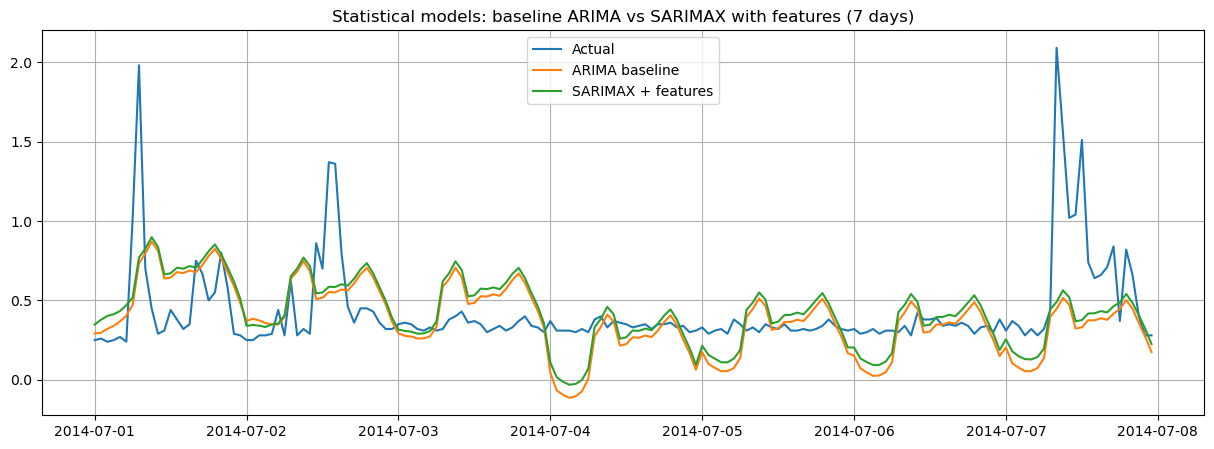

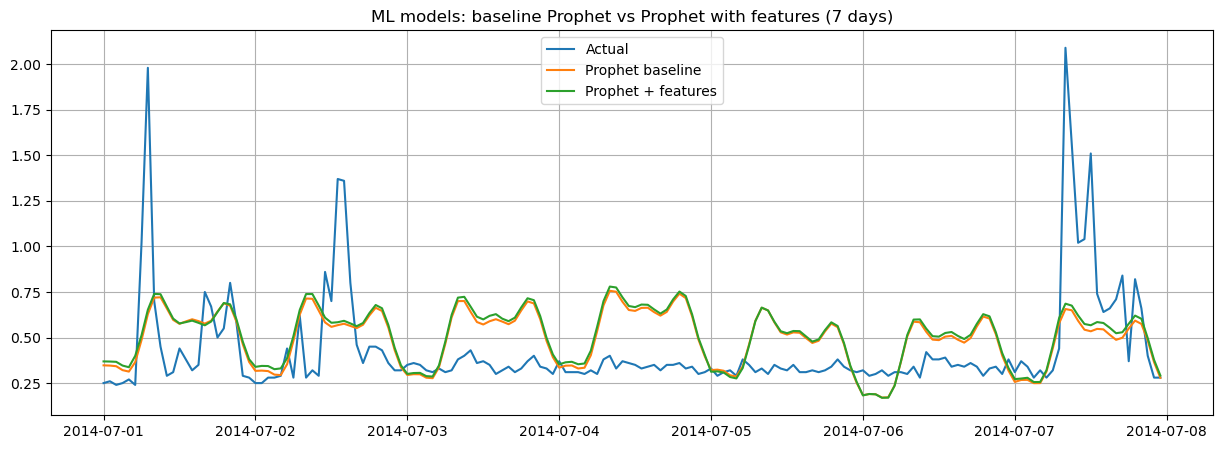

In [57]:
# concatenate predictions for plotting
plot_stat = pd.DataFrame({
    "Actual": pd.concat(stat_preds["Actual"]),
    "ARIMA": pd.concat(stat_preds["ARIMA"]),
    "SARIMAX_features": pd.concat(stat_preds["SARIMAX_features"]),
})

plt.figure(figsize=(15,5))
plt.plot(plot_stat.index, plot_stat["Actual"], label="Actual")
plt.plot(plot_stat.index, plot_stat["ARIMA"], label="ARIMA baseline")
plt.plot(plot_stat.index, plot_stat["SARIMAX_features"], label="SARIMAX + features")
plt.grid(True)
plt.legend()
plt.title("Statistical models: baseline ARIMA vs SARIMAX with features (7 days)")
plt.show()

plot_ml = pd.DataFrame({
    "Actual": pd.concat(ml_preds["Actual"]),
    "Prophet": pd.concat(ml_preds["Prophet"]),
    "Prophet_features": pd.concat(ml_preds["Prophet_features"]),
})

plt.figure(figsize=(15,5))
plt.plot(plot_ml.index, plot_ml["Actual"], label="Actual")
plt.plot(plot_ml.index, plot_ml["Prophet"], label="Prophet baseline")
plt.plot(plot_ml.index, plot_ml["Prophet_features"], label="Prophet + features")
plt.grid(True)
plt.legend()
plt.title("ML models: baseline Prophet vs Prophet with features (7 days)")
plt.show()
